# Investment Sentiment from the News
This notebook compares several ML models applying them to the task of classifying news headlines sentiment. The models could be used to predict the behaviour of retail investors.

In [1]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DataFrame display settings
pd.set_option('display.max_colwidth', 250)

In [3]:
# Charts display settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})

### Data analysis and visualization

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_66Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_AllAgree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/README.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/License.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_75Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_50Agree.txt


In [5]:
data = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',
                   header=None,
                   names=['sentiment', 'text'],
                   encoding='latin-1',
                   dtype={'sentiment': 'category'})

In [6]:
# Number of rows and columns
data.shape

(4846, 2)

Text corpus available for analysis and classification is not large. It contains less than 5,000 samples in total. Headline samples are paired with sentiment labels.

In [7]:
# Examples of news classes
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."


Headlines differ in their length and styles. Texts could consist of words or combine words with numbers and percentages. Some samples contain irregular punctuation, double spaces or extra spaces around punctuation marks.

In [8]:
# Balance of classes
classes_distribution = data['sentiment'].value_counts(normalize=True)
classes_distribution

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

Dataset is highly imbalanced. Majority of the samples represent one category - neutral headlines. Negative news account for only 12.5% of the samples.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until


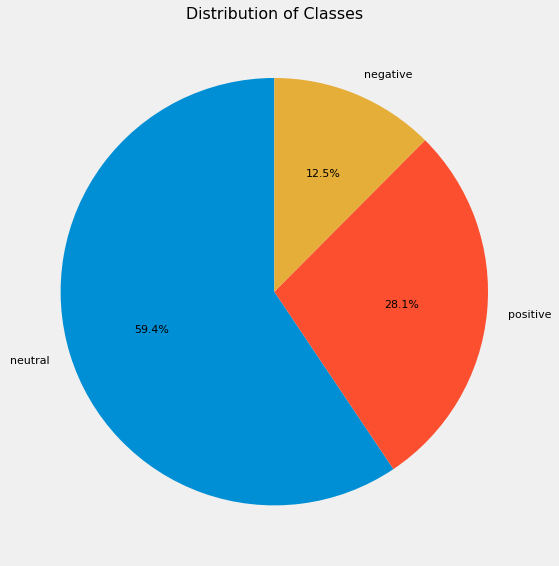

In [9]:
labels = classes_distribution.index
values = classes_distribution.values
plt.pie(values, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.tight_layout()
plt.show()

In [10]:
# Headlines length
data['n_words'] = data['text'].str.split()  # Split sentences by spaces and convert into lists of words
data['n_words'] = data['n_words'].apply(lambda x: [word for word in x if len(word) > 1])  # Remove words shorter than 2 characters
data['n_words'] = data['n_words'].apply(lambda x: len(x))

In [11]:
# Length statistics
min_length = data['n_words'].min()
max_length = data['n_words'].max()
mean_length = data['n_words'].mean()
median_length = data['n_words'].median()

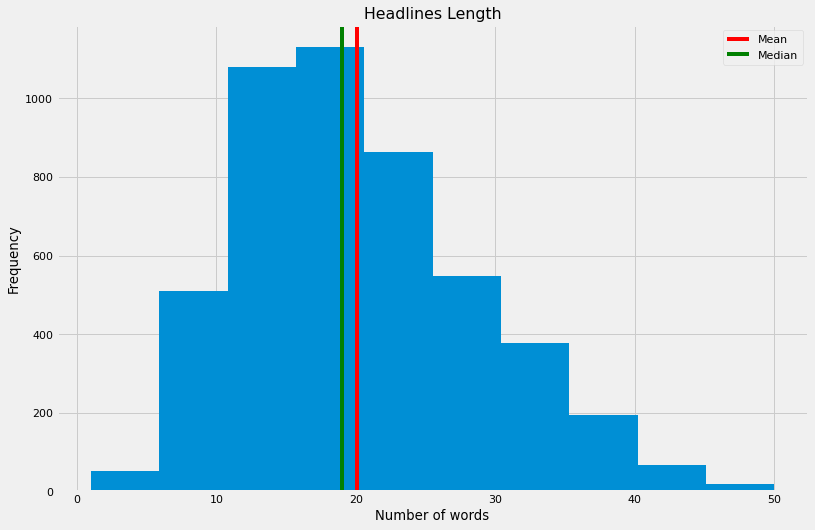

In [12]:
plt.hist(data['n_words'], bins=10)
plt.axvline(mean_length, color='red', label='Mean')
plt.axvline(median_length, color='green', label='Median')
plt.legend()
plt.title('Headlines Length')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

Text samples are not uniform in structure. Headlines length varies greately from just one word to 50 words. Mean length value is about 20 words. Distribution is slightly skewed to the right.

In [13]:
print(f'Sentence length: {min_length} - {max_length} words\nMean length = {mean_length}\nMedian length = {median_length}')

Sentence length: 1 - 50 words
Mean length = 20.103796945934793
Median length = 19.0


In [14]:
# Examples of the shortest headlines
data[data['n_words'] < 5]

,sentiment,text,n_words
176,positive,Cargo volume grew by 7 % .,4
1023,neutral,All are welcome .,3
1116,neutral,Welcome !,1
1461,neutral,You are warmly welcome !,4
1648,positive,The pipeline is strong .,4
2399,neutral,All rights reserved .,3
2518,neutral,Net investment income,3
2554,neutral,Registration is required .,3
2569,neutral,Status : Agreed,2
2972,neutral,Investments are not disclosed .,4


### Functions for modelling

In [15]:
def classification_heatmap(cm):
    """Function produces a heatmap based on the confusion matrix."""
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Reds)
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
def accuracy_estimator(model, name):
    """Function evaluates accuracy metrics for classification model."""
    # Prediction on the test data
    y_pred_class = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_class)
    print(f'{name} model accuracy: {acc}')
    
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    classes_names = le.classes_
    columns = ['pred_' + name for name in classes_names]
    indexes = ['actual_' + name for name in classes_names]
    conf_matrix = pd.DataFrame(conf_matrix, columns=columns, index=indexes)
    classification_heatmap(conf_matrix)
    
    cls_report = classification_report(y_test, y_pred_class, target_names=classes_names)
    print(cls_report)
    
    try:
        y_pred_prob = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
        print(f'ROC AUC = {roc_auc}')
    except Exception as e:
        print('Probability estimations and ROC AUC are not available.')

In [17]:
def sentiment_reader(model, name):
    """Function creates a pipeline that includes preprocessing steps
    and a classifier, fits the model on the training data and
    calls a function to estimate classification accuracy on the test data."""
    pipe = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 3), max_df=0.8)),  # Transform text into tokens using individual words, pairs and triplets
        ('tfidf', TfidfTransformer()),  # Take into account word frequency
        ('clf', model)  # Classification model passed to the function
    ])
    pipe.fit(X_train, y_train)
    accuracy_estimator(pipe, name)

### Compare base sklearn models

In [18]:
# Transform categories into numbers
le = LabelEncoder()
y = le.fit_transform(data['sentiment'])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [19]:
# Withhold 20% of the original data for test purposes.
# Take into account class imbalances during the split stratifying the data accoording to y labels.
X_train, X_test, y_train, y_test = train_test_split(data['text'],
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

NaiveBayes model accuracy: 0.6690721649484536


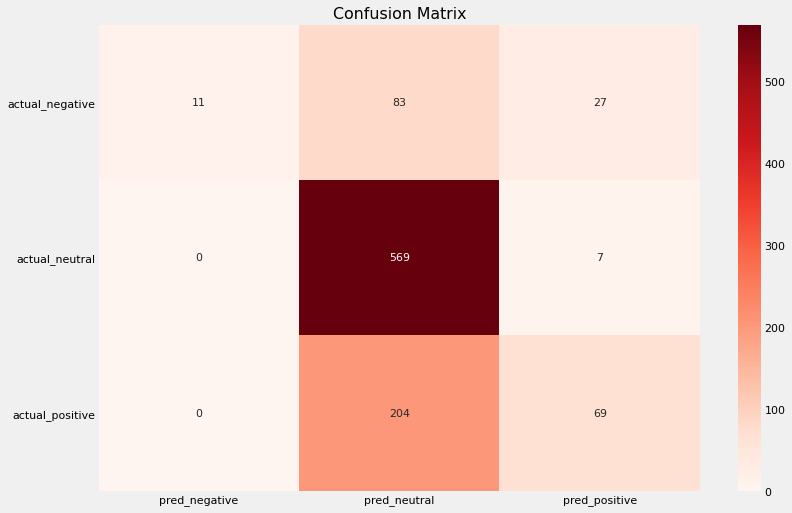

              precision    recall  f1-score   support

    negative       1.00      0.09      0.17       121
     neutral       0.66      0.99      0.79       576
    positive       0.67      0.25      0.37       273

    accuracy                           0.67       970
   macro avg       0.78      0.44      0.44       970
weighted avg       0.71      0.67      0.60       970

ROC AUC = 0.7975707742815074


In [20]:
# Create and evaluate NaiveBayes model with base parameters.
sentiment_reader(MultinomialNB(), 'NaiveBayes')

Accuracy score of this model is higher than the share of the most frequent class in the dataset, but confusion matrix shows that the model is largerly useless. The model fails to correctly classify negative news - the least represented category in the training set. Majority of the samples in the negative category were attributed to the wrong classes. The highest recall was shown for the neutral news. However, the model frequently confuses positive and neutral news, and in the positive category recall is very low. ROC AUC is relatively high, but this high level could not be considered as an indicator of the model's quality. For any practical business purposes it would be more useful to correctly classify the extremes (positive and negative sentiment), which lead to changes in investment behaviour, than to be pricise in labelling neutral sentiment.

LogisticRegression model accuracy: 0.7453608247422681


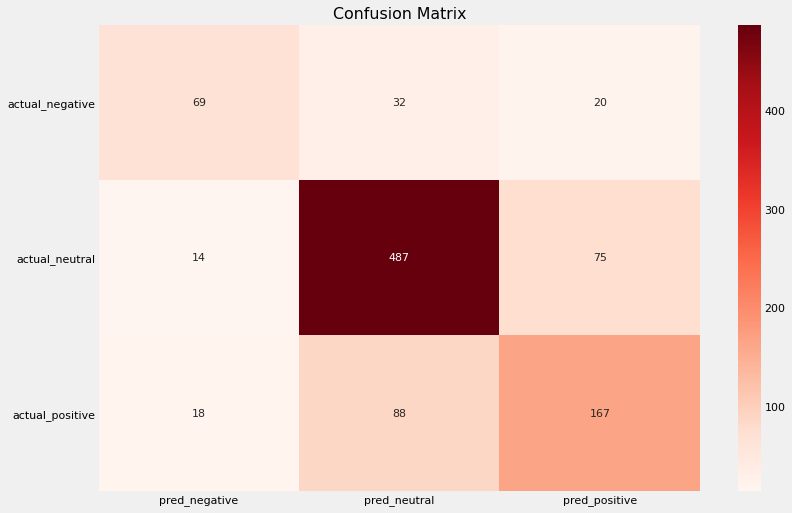

              precision    recall  f1-score   support

    negative       0.68      0.57      0.62       121
     neutral       0.80      0.85      0.82       576
    positive       0.64      0.61      0.62       273

    accuracy                           0.75       970
   macro avg       0.71      0.68      0.69       970
weighted avg       0.74      0.75      0.74       970

ROC AUC = 0.8592442232087021


In [21]:
# Create and evaluate LogisticRegression model specifying 'class_weight' parameter as 'balanced'
# to compensate for class imbalances. Large 'max_iter' will ensure that the model converges.
sentiment_reader(LogisticRegression(class_weight='balanced', max_iter=1000), 'LogisticRegression')

Logistic regression model demonstrated higher accuracy score and higher ROC AUC compared to the previous model. This model is more adequate for the task at hand. In each category the largest numbers in the confusion matrix are located on the main diagonal. Both precision and recall scores are above 50%, which proves that the model is not just guessing and randomly assigning classes. However, prediction accuracy for negative and positive news is still not high enough to use this model for any business decisions.

SGDClassifier model accuracy: 0.7783505154639175


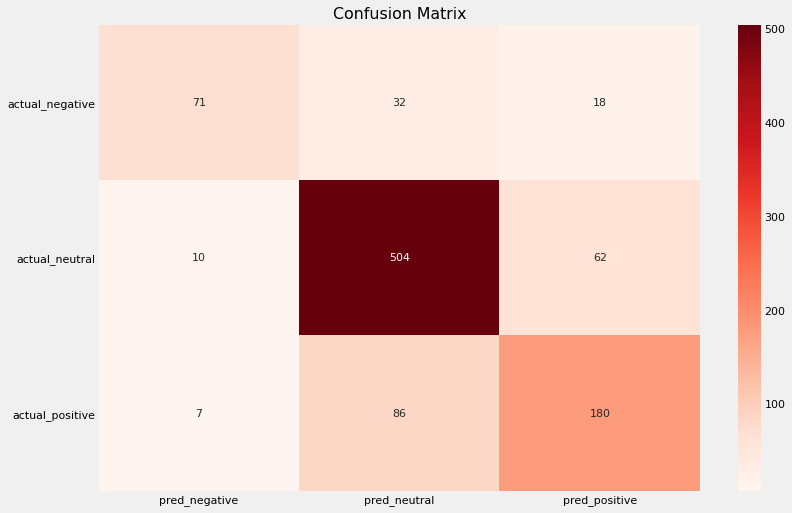

              precision    recall  f1-score   support

    negative       0.81      0.59      0.68       121
     neutral       0.81      0.88      0.84       576
    positive       0.69      0.66      0.68       273

    accuracy                           0.78       970
   macro avg       0.77      0.71      0.73       970
weighted avg       0.78      0.78      0.77       970

Probability estimations and ROC AUC are not available.


In [22]:
# Create and evaluate SGDClassifier with linear SVM parameters and balanced class weights.
sentiment_reader(SGDClassifier(class_weight='balanced', loss='hinge', penalty='l2', tol=None), 'SGDClassifier')

SGDClassifier showed the highest accuracy among the three tested sklearn models, though error rate in the least represented categories is still high. Only about 59% of the actual negative news are correctly classified, which is not nearly enough recall to use for actual investment decisions. In the positive category recall is 0.66 and precision is 0.69, which is also rather mediocre.

Experiments with optimizing model parameters through grid search did not resolve this issue. The data is highly imbalanced and most important classes are underrepresented. There is evidence that grid search on imbalanced classes of data does not lead to satisfactory results.

### Balancing the classes
To resolve the issue with underrepresented classes and improve recall and precision metrics we will try to balance the classes in the dataset. Two approaches are possible:
- Make all three classes equally represented in the training and test set.
- Reduce the number of samples in the prevailing category to make it proportional to the second most represented group.

Testing showed that the first approach leads to higher increase in accuracy scores.

In [23]:
# Number of samples in the least represented class
quota = data['sentiment'].value_counts().min()
quota

604

In [24]:
# New DataFrame to add equal number of samples from each class
balanced_data = pd.DataFrame(columns=['sentiment', 'text'])

In [25]:
# Reduce each group to the chosen number of samples
data_groups = data.groupby('sentiment')
for group in data_groups.indices:
    reduced_class = data_groups.get_group(group)[['sentiment', 'text']].iloc[:quota, :]
    balanced_data = balanced_data.append(reduced_class, ignore_index=True)

In [26]:
# Class distribution in the new dataset
balanced_data['sentiment'].value_counts()

negative    604
neutral     604
positive    604
Name: sentiment, dtype: int64

In [27]:
# Target values
y = le.fit_transform(balanced_data['sentiment'])

In [28]:
# Training and test samples
X_train, X_test, y_train, y_test = train_test_split(balanced_data['text'],
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=1)

SGDClassifier model accuracy: 0.8264462809917356


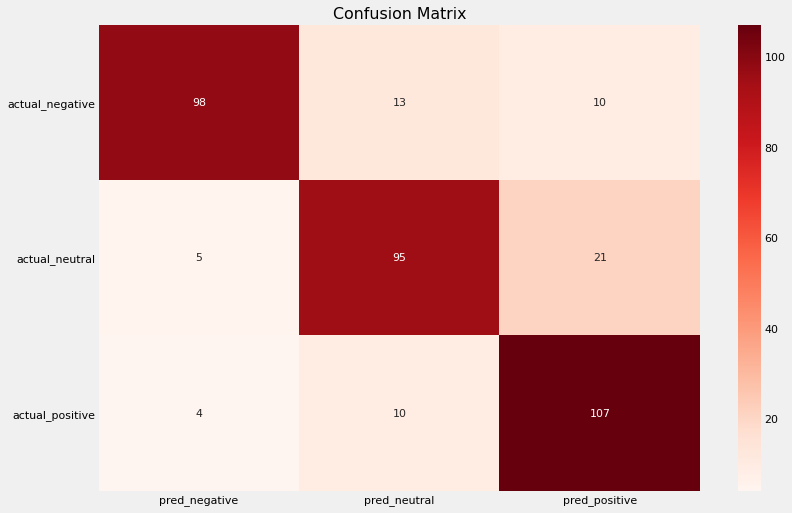

              precision    recall  f1-score   support

    negative       0.92      0.81      0.86       121
     neutral       0.81      0.79      0.79       121
    positive       0.78      0.88      0.83       121

    accuracy                           0.83       363
   macro avg       0.83      0.83      0.83       363
weighted avg       0.83      0.83      0.83       363

Probability estimations and ROC AUC are not available.


In [29]:
# Create and evaluate SGDClassifier model
sentiment_reader(SGDClassifier(loss='hinge', penalty='l2', tol=None), 'SGDClassifier')

All the metrics improved considerably:
- Recall score for negative and positive categories increased to acceptable levels. However prediction accuracy for the neutral news category slightly decreased compared to the previous trial when we used all the data available for this group.
- Precision score increased for the underrepresented groups without negative side effects to the neutral category.

Lets check if this model makes sense when we train it on the balanced dataset without withholding a test portion and then evaluate the accuracy on all available samples from the original unreduced dataset.

In [30]:
# Instantiate the model and train it on balanced dataset without withholding test samples.
X = balanced_data['text']

pipe = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 3), max_df=0.8)),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', tol=None))
    ])
pipe.fit(X, y)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.8, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(tol=None))])

In [31]:
# Accuracy on this training dataset
pipe.score(X, y)

0.9988962472406181

In [32]:
# Make a prediction on the unreduced original dataset
unreduced_X = data['text']
unreduced_y = le.transform(data['sentiment'])
pipe.score(unreduced_X, unreduced_y)

0.7552620718118036

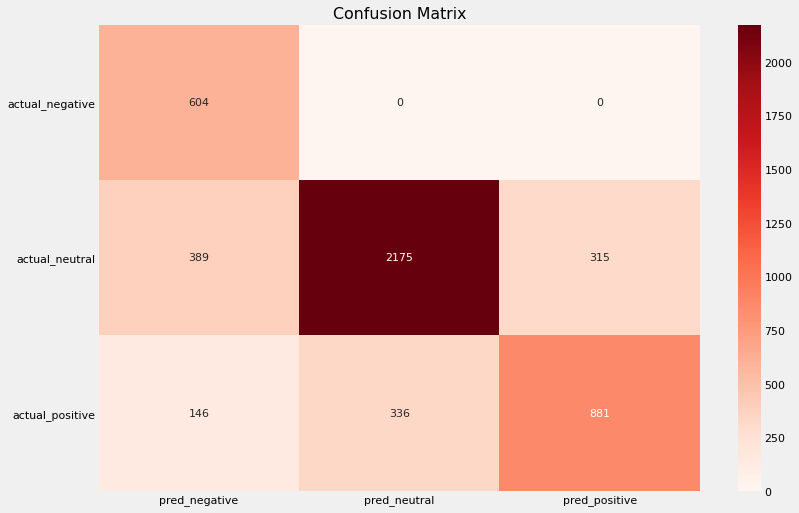

In [33]:
# Confusion matrix
predicted_y = pipe.predict(unreduced_X)
conf_matrix = confusion_matrix(unreduced_y, predicted_y)

classes_names = le.classes_
columns = ['pred_' + name for name in classes_names]
indexes = ['actual_' + name for name in classes_names]
conf_matrix = pd.DataFrame(conf_matrix, columns=columns, index=indexes)

classification_heatmap(conf_matrix)

If we compare this confusion matrix with the case, when we trained the model on unbalanced dataset and checked the accuracy on the test data, there is obvious improvement. The model learned to differentiate negative news from other news categories with high degree of accuracy. However, we should remember that in this training the model saw all available negative samples. It's still unclear if this recall score will be the same in testing on any new samples.

Confusion between positive and neutral news is still visible on the chart. The model did not see all positive news samples during the training process, which confirmes that this approach only partially solves the issue with imbalanced classes.

We can conclude that the best approach to solve this classification problem would be to increase the dataset and find additional text samples to add to the negative and positive sentiment categories. All categories should be more or less equally represented. Imbalances in the original data prevent the models from correctly learning distinctive features for sentiment categories. Dropping samples from overrepresented groups inreases accuracy scores but potentially harms the training process because we limit the available training set.

In [34]:
# Try to get a prediction for out of sample headlines with obvious sentiment.
new_samples = ['Experts expect the world economy to grow at a steady rate of 3% a year.',
               'Local retailers reported much lower revenues this year. Expansion plans are suspended.']
prediction = pipe.predict(new_samples)
for pred in prediction:
    print(le.classes_[pred])

positive
negative
